# Preprocessing CIC-IDS2017 Berdasarkan Jurnal

**Referensi**: "Uncertainty-Aware Adaptive Intrusion Detection Using Hybrid CNN-LSTM with cWGAN-GP Augmentation and Human-in-the-Loop Feedback" (Safety 2025, 11, 120)

**Metodologi**:
1. Load Data
2. Label Collapsing & Filtering
3. **Split Test 15% DULU** (setelah label collapse, sebelum preprocessing apapun)
4. Preprocessing pada 85% data (train+val):
   - Step 1: Drop Environmental Leakage Fields
   - Step 2: Canonicalize columns (lower-case, no spaces)
   - Step 3: Convert non-numeric to numeric
   - Step 4: Remove NaN and infinite values
   - Step 6: Duplicate removal
   - Step 7: Zero-variance & correlation pruning (>0.95)
   - Step 8: Split 85% menjadi Train (70%) dan Validation (15%)
   - Step 9: QuantileTransformer + MinMaxScaler (fitted on train only)
   - Step 10: Consensus Feature Selection
   - Step 11: Data Balancing (VAE + cWGAN-GP untuk minority classes)

**Catatan Penting**: 
- Test set (15%) TIDAK di-preprocess sama sekali (kecuali label collapse)
- Semua preprocessing hanya dilakukan pada train+val (85%)
- Test set akan di-transform saat inference menggunakan transformer yang di-fit pada train

**Catatan**: Untuk eksperimen ini, kita abaikan file-level leakage.


## 1. Setup & Konfigurasi


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Directories
ART_DIR = Path("./artifacts_journal_based")
ART_DIR.mkdir(parents=True, exist_ok=True)

# Preprocessing parameters (berdasarkan jurnal)
CORR_THRESHOLD = 0.95  # Correlation pruning threshold
TEST_SIZE = 0.15  # 15% untuk test
VAL_SIZE = 0.15 / 0.85  # 15% dari 85% = ~17.65% dari data setelah test split

# Paths
TRANSFORM_META_PATH = ART_DIR / 'transform_meta.pkl'
FEATURE_COLS_PATH = ART_DIR / 'feature_cols.json'
LABEL_MAP_PATH = ART_DIR / 'label_map.json'
TRAIN_PROC_PATH = ART_DIR / 'train_processed.pkl'
VAL_PROC_PATH = ART_DIR / 'val_processed.pkl'
TEST_PROC_PATH = ART_DIR / 'test_processed.pkl'

print(f"Artifacts directory: {ART_DIR}")
print(f"Test size: {TEST_SIZE*100:.1f}%")
print(f"Validation size: {VAL_SIZE*100:.1f}% dari data setelah test split")
print(f"Training size: {(1-VAL_SIZE)*100:.1f}% dari data setelah test split")


Artifacts directory: artifacts_journal_based
Test size: 15.0%
Validation size: 17.6% dari data setelah test split
Training size: 82.4% dari data setelah test split


## 2. Load Data


In [2]:
RAW_FILES = [
    "https://storage.googleapis.com/mlskripsi/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Monday-WorkingHours.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Tuesday-WorkingHours.pcap_ISCX.csv",
    "https://storage.googleapis.com/mlskripsi/Wednesday-workingHours.pcap_ISCX.csv"
]

def load_and_concat(urls):
    """Load semua CSV dan gabungkan"""
    dfs = []
    for u in urls:
        df_part = pd.read_csv(u)
        df_part['source_file'] = u.rsplit('/', 1)[-1]
        dfs.append(df_part)
        print(f"Loaded: {df_part['source_file'].iloc[0]} ({df_part.shape[0]:,} rows)")
    raw = pd.concat(dfs, ignore_index=True)
    raw.columns = [c.replace('\ufeff','').strip() if isinstance(c, str) else c for c in raw.columns]
    return raw

raw_df = load_and_concat(RAW_FILES)
print(f"\nTotal raw shape: {raw_df.shape}")
print(f"Total columns: {len(raw_df.columns)}")


Loaded: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (225,745 rows)
Loaded: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (286,467 rows)
Loaded: Friday-WorkingHours-Morning.pcap_ISCX.csv (191,033 rows)
Loaded: Monday-WorkingHours.pcap_ISCX.csv (529,918 rows)
Loaded: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (288,602 rows)
Loaded: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (170,366 rows)
Loaded: Tuesday-WorkingHours.pcap_ISCX.csv (445,909 rows)
Loaded: Wednesday-workingHours.pcap_ISCX.csv (692,703 rows)

Total raw shape: (2830743, 80)
Total columns: 80


## 3. EDA: Analisis Data Awal


In [3]:
print("="*80)
print("EDA: ANALISIS DATA AWAL")
print("="*80)

print(f"\n1. DIMENSI DATA:")
print(f"   Rows: {raw_df.shape[0]:,}")
print(f"   Columns: {raw_df.shape[1]}")

print(f"\n2. KOLOM YANG ADA:")
print(f"   Total kolom: {len(raw_df.columns)}")
print(f"   Sample kolom (10 pertama):")
for i, col in enumerate(raw_df.columns[:10], 1):
    print(f"     {i}. {col}")

# Cek kolom yang akan di-drop (environmental leakage)
leakage_cols = []
for col in raw_df.columns:
    col_lower = col.lower()
    if any(x in col_lower for x in ['source ip', 'destination ip', 'ip', 'port', 'protocol', 'timestamp', 'time']):
        if col not in ['Label', 'source_file']:
            leakage_cols.append(col)

print(f"\n3. KOLOM YANG AKAN DI-DROP (Environmental Leakage Prevention):")
print(f"   Total: {len(leakage_cols)} kolom")
if leakage_cols:
    for col in leakage_cols[:10]:
        print(f"     - {col}")
    if len(leakage_cols) > 10:
        print(f"     ... dan {len(leakage_cols)-10} kolom lainnya")

# Cek label
label_col = None
for col in raw_df.columns:
    if 'label' in col.lower():
        label_col = col
        break

if label_col:
    print(f"\n4. LABEL COLUMN: {label_col}")
    print(f"   Unique labels: {raw_df[label_col].nunique()}")
    print(f"   Label distribution:")
    label_dist = raw_df[label_col].value_counts()
    for label, count in label_dist.head(10).items():
        print(f"     {label}: {count:,} ({count/len(raw_df)*100:.2f}%)")
else:
    print("\n4. LABEL COLUMN: Tidak ditemukan!")

# Cek missing values
print(f"\n5. MISSING VALUES:")
missing = raw_df.isna().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print(f"   Kolom dengan missing values: {len(missing_cols)}")
    print(f"   Top 10 kolom dengan missing terbanyak:")
    for col, count in missing_cols.head(10).items():
        print(f"     {col}: {count:,} ({count/len(raw_df)*100:.2f}%)")
else:
    print("   Tidak ada missing values")

# Cek infinite values
print(f"\n6. INFINITE VALUES:")
inf_cols = []
for col in raw_df.select_dtypes(include=[np.number]).columns:
    if np.isinf(raw_df[col]).any():
        inf_cols.append(col)
if inf_cols:
    print(f"   Kolom dengan infinite values: {len(inf_cols)}")
    for col in inf_cols[:10]:
        inf_count = np.isinf(raw_df[col]).sum()
        print(f"     {col}: {inf_count:,} ({inf_count/len(raw_df)*100:.2f}%)")
else:
    print("   Tidak ada infinite values")

# Cek duplicates
print(f"\n7. DUPLICATES:")
dups = raw_df.duplicated().sum()
print(f"   Duplicate rows: {dups:,} ({dups/len(raw_df)*100:.2f}%)")


EDA: ANALISIS DATA AWAL

1. DIMENSI DATA:
   Rows: 2,830,743
   Columns: 80

2. KOLOM YANG ADA:
   Total kolom: 80
   Sample kolom (10 pertama):
     1. Destination Port
     2. Flow Duration
     3. Total Fwd Packets
     4. Total Backward Packets
     5. Total Length of Fwd Packets
     6. Total Length of Bwd Packets
     7. Fwd Packet Length Max
     8. Fwd Packet Length Min
     9. Fwd Packet Length Mean
     10. Fwd Packet Length Std

3. KOLOM YANG AKAN DI-DROP (Environmental Leakage Prevention):
   Total: 1 kolom
     - Destination Port

4. LABEL COLUMN: Label
   Unique labels: 15
   Label distribution:
     BENIGN: 2,273,097 (80.30%)
     DoS Hulk: 231,073 (8.16%)
     PortScan: 158,930 (5.61%)
     DDoS: 128,027 (4.52%)
     DoS GoldenEye: 10,293 (0.36%)
     FTP-Patator: 7,938 (0.28%)
     SSH-Patator: 5,897 (0.21%)
     DoS slowloris: 5,796 (0.20%)
     DoS Slowhttptest: 5,499 (0.19%)
     Bot: 1,966 (0.07%)

5. MISSING VALUES:
   Kolom dengan missing values: 1
   Top 10 kolo

## 4. Label Collapsing & Filtering

**Tujuan**: Collapse label ke 5 kelas target (BENIGN, DDoS, DoS, Port Scan, Brute Force) dan filter data hanya untuk kelas-kelas tersebut.


In [4]:
# Label collapsing (sama seperti sebelumnya)
def normalize_label(label_str):
    if pd.isna(label_str):
        return None
    return str(label_str).strip().lower()

def collapse_rule(normalized_label):
    if not normalized_label:
        return None
    normalized_label = normalized_label.lower()
    if 'benign' in normalized_label:
        return 'BENIGN'
    elif 'ddos' in normalized_label:
        return 'DDoS'
    elif 'dos' in normalized_label and 'ddos' not in normalized_label:
        return 'DoS'
    elif 'port' in normalized_label and 'scan' in normalized_label:
        return 'Port Scan'
    elif 'patator' in normalized_label or 'brute' in normalized_label:
        return 'Brute Force'
    return None

# Detect label column
label_col = None
for col in raw_df.columns:
    if 'label' in col.lower():
        label_col = col
        break

if not label_col:
    raise ValueError("Label column not found")

print(f"Using label column: {label_col}")

# Apply label collapsing
raw_df['Label_original'] = raw_df[label_col]
raw_df['Label_collapsed'] = raw_df[label_col].fillna('').astype(str).apply(
    lambda x: collapse_rule(normalize_label(x))
)

# Filter to target classes
targets = ['BENIGN', 'DDoS', 'DoS', 'Port Scan', 'Brute Force']
raw_df_filtered = raw_df[
    raw_df['Label_collapsed'].notna() & 
    raw_df['Label_collapsed'].isin(targets)
].copy()

print(f"\nAfter filtering to target classes: {len(raw_df_filtered):,} rows")
print(f"\nClass distribution:")
class_dist = raw_df_filtered['Label_collapsed'].value_counts()
for label, count in class_dist.items():
    print(f"  {label}: {count:,} ({count/len(raw_df_filtered)*100:.2f}%)")

# Build label map
label_map = {lab: idx for idx, lab in enumerate(sorted(targets))}
inv_label_map = {idx: lab for lab, idx in label_map.items()}

print(f"\nLabel map: {label_map}")


Using label column: Label

After filtering to target classes: 2,828,057 rows

Class distribution:
  BENIGN: 2,273,097 (80.38%)
  DoS: 252,661 (8.93%)
  Port Scan: 158,930 (5.62%)
  DDoS: 128,027 (4.53%)
  Brute Force: 15,342 (0.54%)

Label map: {'BENIGN': 0, 'Brute Force': 1, 'DDoS': 2, 'DoS': 3, 'Port Scan': 4}


## 5. EDA: Visualisasi Distribusi Label

**Tujuan**: Memvisualisasikan distribusi label setelah collapsing untuk memahami karakteristik dataset.


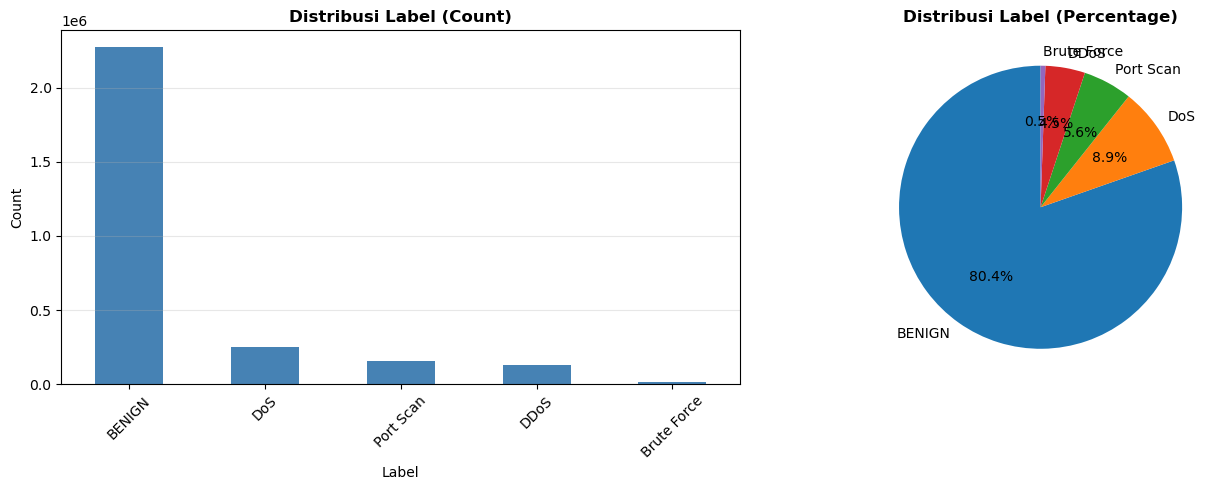

Visualisasi disimpan ke: artifacts_journal_based/eda_label_distribution.png


In [5]:
# Visualisasi distribusi label
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_dist.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Distribusi Label (Count)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Label', fontsize=10)
axes[0].set_ylabel('Count', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
class_dist.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribusi Label (Percentage)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig(ART_DIR / 'eda_label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Visualisasi disimpan ke:", ART_DIR / 'eda_label_distribution.png')


## 6. Step 5: Split Test 15% DULU (Tanpa Preprocessing)

**Berdasarkan jurnal**: Test set harus di-split DULU sebelum preprocessing apapun (kecuali label collapsing & filtering yang sudah dilakukan).

**Catatan**: 
- Test set (15%) akan tetap dalam kondisi setelah label collapse
- Semua preprocessing (drop leakage, canonicalize, convert numeric, remove NaN/Inf, dll) hanya dilakukan pada train+val (85%)
- Test set akan di-transform saat inference menggunakan transformer yang di-fit pada train


STEP 5: SPLIT TEST 15% DULU (TANPA PREPROCESSING)



Split results:
  Train+Val (85%): 2,403,848 rows
  Test (15%): 424,209 rows

Class distribution - Train+Val:
Label_collapsed
BENIGN         1932132
Brute Force      13041
DDoS            108823
DoS             214762
Port Scan       135090
Name: count, dtype: int64

Class distribution - Test:
Label_collapsed
BENIGN         340965
Brute Force      2301
DDoS            19204
DoS             37899
Port Scan       23840
Name: count, dtype: int64


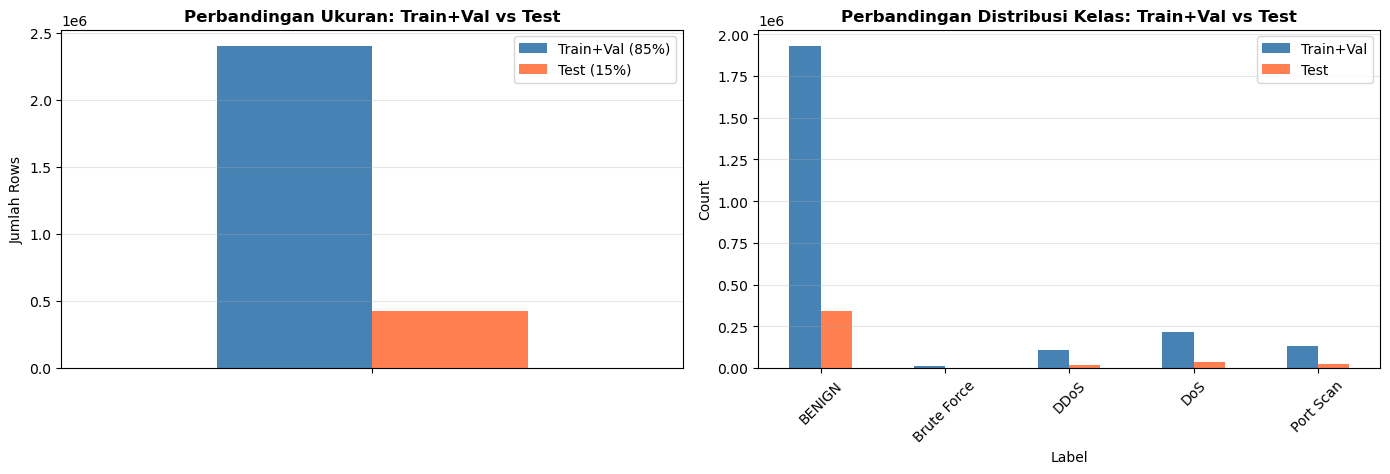


Visualisasi disimpan ke: artifacts_journal_based/step5_test_split.png

CATATAN: Test set (424,209 rows) TIDAK akan di-preprocess
   Test set hanya akan digunakan untuk evaluasi final
   Semua preprocessing berikutnya hanya dilakukan pada train+val (85%)


In [6]:
print("="*80)
print("STEP 5: SPLIT TEST 15% DULU (TANPA PREPROCESSING)")
print("="*80)

# Split test 15% SETELAH label collapsing & filtering
# Test set TIDAK akan di-preprocess, hanya digunakan untuk evaluasi final
df_for_split = raw_df_filtered.copy()

# Catatan: Kolom label masih 'Label_collapsed' (belum canonicalize)
# Setelah canonicalize akan menjadi 'label_collapsed'
label_col_for_split = 'Label_collapsed'  # Nama kolom sebelum canonicalize

# Stratified split untuk test (15%)
df_trainval_raw, df_test_raw = train_test_split(
    df_for_split,
    test_size=TEST_SIZE,
    stratify=df_for_split[label_col_for_split],
    random_state=RANDOM_STATE
)

print(f"\nSplit results:")
print(f"  Train+Val (85%): {len(df_trainval_raw):,} rows")
print(f"  Test (15%): {len(df_test_raw):,} rows")

print(f"\nClass distribution - Train+Val:")
print(df_trainval_raw[label_col_for_split].value_counts().sort_index())

print(f"\nClass distribution - Test:")
print(df_test_raw[label_col_for_split].value_counts().sort_index())

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Size comparison
size_df = pd.DataFrame({
    'Train+Val (85%)': [len(df_trainval_raw)],
    'Test (15%)': [len(df_test_raw)]
}, index=['Jumlah Rows'])
size_df.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Perbandingan Ukuran: Train+Val vs Test', fontweight='bold')
axes[0].set_ylabel('Jumlah Rows')
axes[0].set_xticklabels([''], rotation=0)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Class distribution comparison
trainval_dist = df_trainval_raw[label_col_for_split].value_counts().sort_index()
test_dist = df_test_raw[label_col_for_split].value_counts().sort_index()
dist_comparison = pd.DataFrame({
    'Train+Val': trainval_dist,
    'Test': test_dist
}).fillna(0)
dist_comparison.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('Perbandingan Distribusi Kelas: Train+Val vs Test', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Label')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(ART_DIR / 'step5_test_split.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step5_test_split.png'}")
print(f"\nCATATAN: Test set ({len(df_test_raw):,} rows) TIDAK akan di-preprocess")
print(f"   Test set hanya akan digunakan untuk evaluasi final")
print(f"   Semua preprocessing berikutnya hanya dilakukan pada train+val (85%)")


## 7. Step 1: Drop Environmental Leakage Fields (Hanya pada Train+Val)

**Berdasarkan jurnal**: "To prevent environmental leakage, the field (source/destination IP, port, and protocol) and timestamp fields are stripped from each record."

**Catatan**: Preprocessing ini hanya dilakukan pada train+val (85%). Test set tetap dalam kondisi original.

**Berdasarkan jurnal**: "To prevent environmental leakage, the field (source/destination IP, port, and protocol) and timestamp fields are stripped from each record."


In [7]:
print("="*80)
print("STEP 1: DROP ENVIRONMENTAL LEAKAGE FIELDS (TRAIN+VAL ONLY)")
print("="*80)

# Preprocessing hanya pada train+val
df_trainval_step0 = df_trainval_raw.copy()

# Tampilkan semua kolom yang ada untuk debugging
print(f"\nSEMUA KOLOM YANG ADA ({len(df_trainval_step0.columns)} kolom):")
for i, col in enumerate(df_trainval_step0.columns, 1):
    print(f"  {i:2d}. {col}")

# Identifikasi kolom yang akan di-drop - keyword lebih komprehensif
leakage_keywords = [
    'source ip', 'destination ip', 'src ip', 'dst ip', 'source_ip', 'destination_ip', 'src_ip', 'dst_ip',
    'source ipv4', 'destination ipv4', 'src ipv4', 'dst ipv4',
    'ip address', 'ipaddr', 'ip_addr',
    'source port', 'destination port', 'src port', 'dst port', 'source_port', 'destination_port', 'src_port', 'dst_port',
    'port',
    'protocol', 'proto',
    'timestamp', 'time', 'date', 'datetime', 'time_stamp', 'time_stamp_start', 'time_stamp_end',
    'flow start time', 'flow end time', 'start time', 'end time'
]

leakage_cols_to_drop = []

for col in df_trainval_step0.columns:
    col_lower = col.lower().strip()
    # Skip label dan source_file
    if col in ['Label', 'Label_original', 'Label_collapsed', 'source_file']:
        continue
    # Cek apakah mengandung keyword leakage
    if any(keyword in col_lower for keyword in leakage_keywords):
        leakage_cols_to_drop.append(col)

print(f"\n{'='*80}")
print(f"KOLOM YANG AKAN DI-DROP (Environmental Leakage): {len(leakage_cols_to_drop)}")
if leakage_cols_to_drop:
    for col in leakage_cols_to_drop:
        print(f"  - {col}")
else:
    print("  ⚠️ Tidak ada kolom leakage yang terdeteksi!")
    print("  Catatan: Dataset CIC-IDS2017 mungkin sudah tidak memiliki kolom IP address")
    print("  (kolom IP mungkin sudah di-strip oleh pembuat dataset)")

# Drop leakage columns (HANYA pada train+val)
df_step1 = df_trainval_step0.drop(columns=leakage_cols_to_drop, errors='ignore').copy()

print(f"\nSebelum drop: {df_trainval_step0.shape[1]} kolom")
print(f"Sesudah drop: {df_step1.shape[1]} kolom")
print(f"Dropped: {len(leakage_cols_to_drop)} kolom")
print(f"\nCATATAN: Test set TIDAK di-drop leakage fields (akan di-drop saat inference)")

# # Visualisasi
# fig, ax = plt.subplots(figsize=(10, 6))
# before_after = pd.DataFrame({
#     'Sebelum': [raw_df_filtered.shape[1]],
#     'Sesudah': [df_step1.shape[1]]
# }, index=['Jumlah Kolom'])
# before_after.plot(kind='bar', ax=ax, color=['coral', 'lightblue'])
# ax.set_title('Perbandingan Jumlah Kolom: Sebelum vs Sesudah Drop Leakage Fields', fontweight='bold')
# ax.set_ylabel('Jumlah Kolom')
# ax.set_xticklabels([''], rotation=0)
# ax.legend()
# ax.grid(axis='y', alpha=0.3)
# plt.tight_layout()
# plt.savefig(ART_DIR / 'step1_drop_leakage.png', dpi=150, bbox_inches='tight')
# plt.show()

# print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step1_drop_leakage.png'}")


STEP 1: DROP ENVIRONMENTAL LEAKAGE FIELDS (TRAIN+VAL ONLY)

SEMUA KOLOM YANG ADA (82 kolom):
   1. Destination Port
   2. Flow Duration
   3. Total Fwd Packets
   4. Total Backward Packets
   5. Total Length of Fwd Packets
   6. Total Length of Bwd Packets
   7. Fwd Packet Length Max
   8. Fwd Packet Length Min
   9. Fwd Packet Length Mean
  10. Fwd Packet Length Std
  11. Bwd Packet Length Max
  12. Bwd Packet Length Min
  13. Bwd Packet Length Mean
  14. Bwd Packet Length Std
  15. Flow Bytes/s
  16. Flow Packets/s
  17. Flow IAT Mean
  18. Flow IAT Std
  19. Flow IAT Max
  20. Flow IAT Min
  21. Fwd IAT Total
  22. Fwd IAT Mean
  23. Fwd IAT Std
  24. Fwd IAT Max
  25. Fwd IAT Min
  26. Bwd IAT Total
  27. Bwd IAT Mean
  28. Bwd IAT Std
  29. Bwd IAT Max
  30. Bwd IAT Min
  31. Fwd PSH Flags
  32. Bwd PSH Flags
  33. Fwd URG Flags
  34. Bwd URG Flags
  35. Fwd Header Length
  36. Bwd Header Length
  37. Fwd Packets/s
  38. Bwd Packets/s
  39. Min Packet Length
  40. Max Packet Lengt

## 8. Step 2: Canonicalize Columns (Hanya pada Train+Val)

**Berdasarkan jurnal**: "The columns were canonicalized (lower-case and no spaces)"

**Catatan**: Preprocessing ini hanya dilakukan pada train+val. Test set tetap dalam kondisi original.

**Berdasarkan jurnal**: "The columns were canonicalized (lower-case and no spaces)"


STEP 2: CANONICALIZE COLUMNS



Kolom yang berubah: 78
Sample perubahan (10 pertama):
  'Flow Duration' → 'flow_duration'
  'Total Fwd Packets' → 'total_fwd_packets'
  'Total Backward Packets' → 'total_backward_packets'
  'Total Length of Fwd Packets' → 'total_length_of_fwd_packets'
  'Total Length of Bwd Packets' → 'total_length_of_bwd_packets'
  'Fwd Packet Length Max' → 'fwd_packet_length_max'
  'Fwd Packet Length Min' → 'fwd_packet_length_min'
  'Fwd Packet Length Mean' → 'fwd_packet_length_mean'
  'Fwd Packet Length Std' → 'fwd_packet_length_std'
  'Bwd Packet Length Max' → 'bwd_packet_length_max'

Total kolom: 81


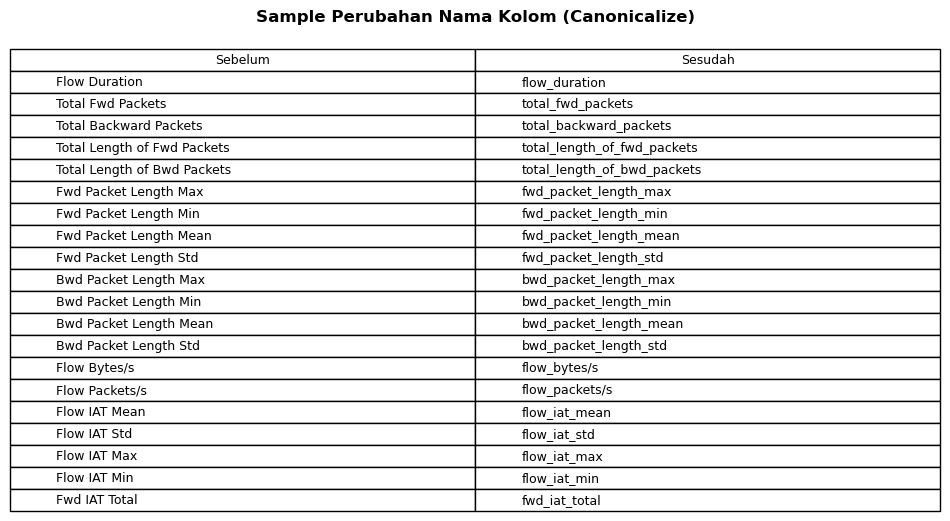


Visualisasi disimpan ke: artifacts_journal_based/step2_canonicalize.png


In [8]:
print("="*80)
print("STEP 2: CANONICALIZE COLUMNS")
print("="*80)

# Simpan nama kolom sebelum canonicalize
cols_before = df_step1.columns.tolist()

# Canonicalize: lower-case dan no spaces
def canonicalize_col_name(col):
    if not isinstance(col, str):
        return col
    # Lower case
    col = col.lower()
    # Remove spaces, replace with underscore
    col = col.replace(' ', '_').replace('-', '_')
    # Remove multiple underscores
    while '__' in col:
        col = col.replace('__', '_')
    # Remove leading/trailing underscores
    col = col.strip('_')
    return col

df_step2 = df_step1.copy()
df_step2.columns = [canonicalize_col_name(col) for col in df_step2.columns]

# Cek perubahan
cols_after = df_step2.columns.tolist()
changes = [(before, after) for before, after in zip(cols_before, cols_after) if before != after]

print(f"\nKolom yang berubah: {len(changes)}")
if changes:
    print("Sample perubahan (10 pertama):")
    for before, after in changes[:10]:
        print(f"  '{before}' → '{after}'")

print(f"\nTotal kolom: {len(df_step2.columns)}")

# Visualisasi
if changes:
    fig, ax = plt.subplots(figsize=(12, 6))
    change_df = pd.DataFrame(changes[:20], columns=['Sebelum', 'Sesudah'])
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=change_df.values, colLabels=change_df.columns,
                     cellLoc='left', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax.set_title('Sample Perubahan Nama Kolom (Canonicalize)', fontweight='bold', pad=20)
    plt.savefig(ART_DIR / 'step2_canonicalize.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step2_canonicalize.png'}")


## 8. Step 3: Convert Non-Numeric to Numeric

**Berdasarkan jurnal**: "non-numeric values were converted to numeric values using pandas"


In [9]:
print("="*80)
print("STEP 3: CONVERT NON-NUMERIC TO NUMERIC")
print("="*80)

df_step3 = df_step2.copy()

# Analisis tipe data semua kolom
print(f"\n1. ANALISIS TIPE DATA SEMUA KOLOM:")
exclude_cols = ['label', 'label_original', 'label_collapsed', 'source_file']
dtype_summary = {}

for col in df_step3.columns:
    dtype = str(df_step3[col].dtype)
    if dtype not in dtype_summary:
        dtype_summary[dtype] = []
    dtype_summary[dtype].append(col)

print(f"   Total kolom: {len(df_step3.columns)}")
for dtype, cols in sorted(dtype_summary.items()):
    print(f"   - {dtype}: {len(cols)} kolom")
    if dtype in ['object', 'string', 'category'] and len(cols) <= 10:
        print(f"     Kolom: {', '.join(cols)}")

# Identifikasi kolom non-numeric (kecuali label dan source_file)
non_numeric_cols = []
object_cols = []

for col in df_step3.columns:
    col_lower = col.lower()
    if col_lower in exclude_cols:
        continue
    
    dtype = df_step3[col].dtype
    is_numeric = pd.api.types.is_numeric_dtype(df_step3[col])
    
    if not is_numeric:
        non_numeric_cols.append(col)
        if dtype == 'object':
            object_cols.append(col)

print(f"\n2. KOLOM NON-NUMERIC YANG DITEMUKAN: {len(non_numeric_cols)}")
if non_numeric_cols:
    for col in non_numeric_cols[:10]:
        unique_vals = df_step3[col].nunique()
        dtype = df_step3[col].dtype
        print(f"  - {col} (dtype: {dtype}): {unique_vals} unique values")
        sample_vals = df_step3[col].dropna().head(3).tolist()
        print(f"    Sample values: {sample_vals}")
    if len(non_numeric_cols) > 10:
        print(f"  ... dan {len(non_numeric_cols)-10} kolom lainnya")
else:
    print("  ✓ Tidak ada kolom non-numeric yang perlu dikonversi")
    print("  ✓ Semua kolom (kecuali label dan source_file) sudah bertipe numeric")
    if object_cols:
        print(f"\n  Catatan: Ditemukan {len(object_cols)} kolom dengan dtype 'object'")
        print(f"  tetapi sudah terdeteksi sebagai numeric oleh pandas")

# Convert non-numeric to numeric
conversion_stats = {}
for col in non_numeric_cols:
    try:
        # Coba convert ke numeric
        converted = pd.to_numeric(df_step3[col], errors='coerce')
        # Cek berapa yang berhasil dikonversi
        success_count = converted.notna().sum()
        total_count = len(df_step3)
        conversion_stats[col] = {
            'success': success_count,
            'total': total_count,
            'success_rate': success_count / total_count * 100
        }
        df_step3[col] = converted
    except Exception as e:
        print(f"  Warning: Failed to convert {col}: {e}")

print(f"\nKonversi selesai")
if conversion_stats:
    print(f"\nStatistik konversi:")
    for col, stats in list(conversion_stats.items())[:10]:
        print(f"  {col}: {stats['success']:,}/{stats['total']:,} ({stats['success_rate']:.2f}%)")

# Visualisasi
if conversion_stats:
    conv_df = pd.DataFrame(conversion_stats).T
    fig, ax = plt.subplots(figsize=(12, 6))
    conv_df['success_rate'].plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Success Rate Konversi Non-Numeric ke Numeric', fontweight='bold')
    ax.set_ylabel('Success Rate (%)')
    ax.set_xlabel('Kolom')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(ART_DIR / 'step3_convert_numeric.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step3_convert_numeric.png'}")


STEP 3: CONVERT NON-NUMERIC TO NUMERIC



1. ANALISIS TIPE DATA SEMUA KOLOM:
   Total kolom: 81
   - float64: 24 kolom
   - int64: 53 kolom
   - object: 4 kolom
     Kolom: label, source_file, label_original, label_collapsed

2. KOLOM NON-NUMERIC YANG DITEMUKAN: 0
  ✓ Tidak ada kolom non-numeric yang perlu dikonversi
  ✓ Semua kolom (kecuali label dan source_file) sudah bertipe numeric

Konversi selesai


## 9. Step 4: Remove NaN and Infinite Values

**Berdasarkan jurnal**: "rows containing NaN or infinite values were removed"


STEP 4: REMOVE NaN AND INFINITE VALUES

Sebelum removal:
  Total rows: 2,403,848
  Rows dengan NaN: 1,161 (0.05%)
  Rows dengan Inf: 2,450 (0.10%)

Sesudah removal:
  Total rows: 2,401,398
  Rows dropped: 2,450 (0.10%)


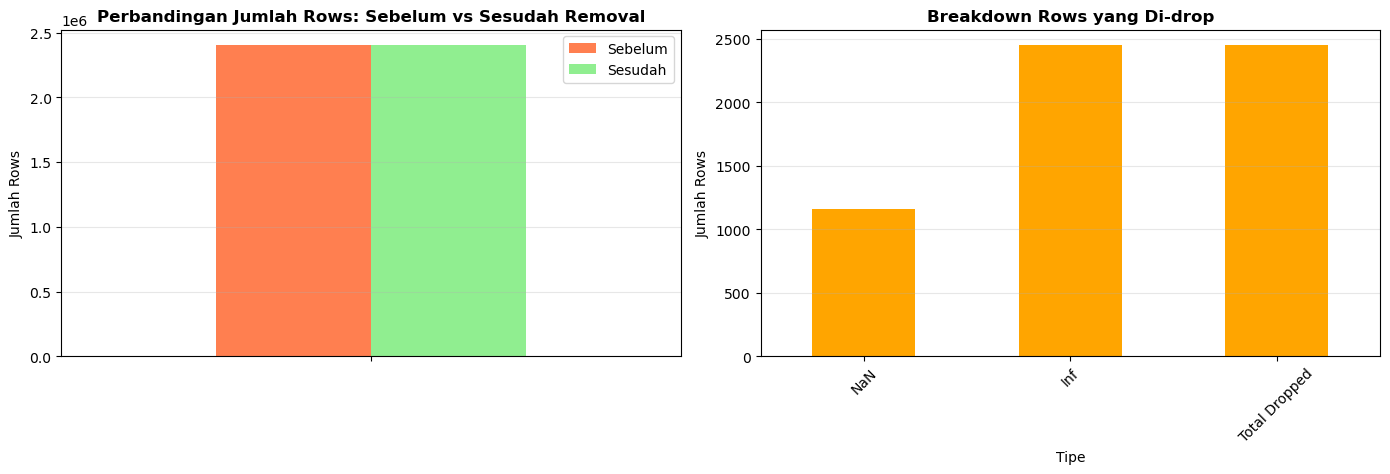


Visualisasi disimpan ke: artifacts_journal_based/step4_remove_nan_inf.png


In [10]:
print("="*80)
print("STEP 4: REMOVE NaN AND INFINITE VALUES")
print("="*80)

df_step4 = df_step3.copy()

# Cek sebelum removal
rows_before = len(df_step4)
nan_rows = df_step4.isna().any(axis=1).sum()

print(f"\nSebelum removal:")
print(f"  Total rows: {rows_before:,}")
print(f"  Rows dengan NaN: {nan_rows:,} ({nan_rows/rows_before*100:.2f}%)")

# Optimasi: Cek infinite values lebih efisien dengan numpy
numeric_cols = df_step4.select_dtypes(include=[np.number]).columns
mask_inf = np.zeros(len(df_step4), dtype=bool)

# Batch processing untuk menghindari memory issue
chunk_size = 100000
for i in range(0, len(df_step4), chunk_size):
    end_idx = min(i + chunk_size, len(df_step4))
    chunk = df_step4.iloc[i:end_idx]
    chunk_mask = np.zeros(end_idx - i, dtype=bool)
    for col in numeric_cols:
        chunk_mask = chunk_mask | np.isinf(chunk[col].values)
    mask_inf[i:end_idx] = chunk_mask

mask_inf = pd.Series(mask_inf, index=df_step4.index)
inf_rows = mask_inf.sum()
print(f"  Rows dengan Inf: {inf_rows:,} ({inf_rows/rows_before*100:.2f}%)")

# Remove rows dengan NaN atau Inf
mask_nan = df_step4.isna().any(axis=1)

mask_to_drop = mask_nan | mask_inf
df_step4 = df_step4[~mask_to_drop].copy()

rows_after = len(df_step4)
rows_dropped = rows_before - rows_after

print(f"\nSesudah removal:")
print(f"  Total rows: {rows_after:,}")
print(f"  Rows dropped: {rows_dropped:,} ({rows_dropped/rows_before*100:.2f}%)")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before/After comparison
before_after = pd.DataFrame({
    'Sebelum': [rows_before],
    'Sesudah': [rows_after]
}, index=['Jumlah Rows'])
before_after.plot(kind='bar', ax=axes[0], color=['coral', 'lightgreen'])
axes[0].set_title('Perbandingan Jumlah Rows: Sebelum vs Sesudah Removal', fontweight='bold')
axes[0].set_ylabel('Jumlah Rows')
axes[0].set_xticklabels([''], rotation=0)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Dropped rows breakdown
dropped_breakdown = pd.DataFrame({
    'NaN': [mask_nan.sum()],
    'Inf': [inf_rows],
    'Total Dropped': [rows_dropped]
}, index=['Rows'])
dropped_breakdown.T.plot(kind='bar', ax=axes[1], color=['orange', 'red', 'darkred'])
axes[1].set_title('Breakdown Rows yang Di-drop', fontweight='bold')
axes[1].set_ylabel('Jumlah Rows')
axes[1].set_xlabel('Tipe')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend().remove()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(ART_DIR / 'step4_remove_nan_inf.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step4_remove_nan_inf.png'}")


## 10. Step 5: Split Test 15% DULU (Tanpa Preprocessing)

**PENTING**: Test set dipisah DULU tanpa preprocessing apapun (hanya drop & collapse label sudah dilakukan). Yang diproses adalah 85% data yang kemudian di-split menjadi train (70%) dan validation (15%).


STEP 5: SPLIT TEST 15% DULU (TANPA PREPROCESSING)

Split results:
  Train+Val (85%): 2,041,188 rows
  Test (15%): 360,210 rows

Class distribution - Train+Val:
label_collapsed
BENIGN         1641018
Brute Force      11082
DDoS             92499
DoS             181853
Port Scan       114736
Name: count, dtype: int64

Class distribution - Test:
label_collapsed
BENIGN         289592
Brute Force      1956
DDoS            16323
DoS             32092
Port Scan       20247
Name: count, dtype: int64


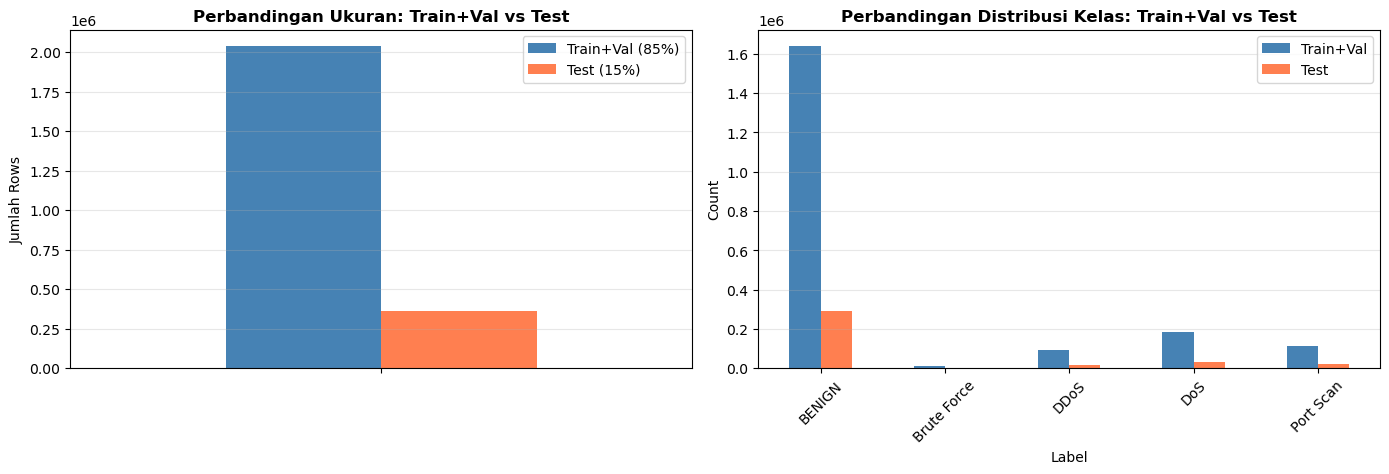


Visualisasi disimpan ke: artifacts_journal_based/step5_test_split.png

⚠️ CATATAN: Test set (360,210 rows) TIDAK akan di-preprocess
   Test set hanya akan digunakan untuk evaluasi final


In [11]:
print("="*80)
print("STEP 5: SPLIT TEST 15% DULU (TANPA PREPROCESSING)")
print("="*80)

# Stratified split untuk test (15%)
# Test set TIDAK akan di-preprocess, hanya digunakan untuk evaluasi final
df_for_split = df_step4.copy()

# Split test 15%
df_trainval, df_test = train_test_split(
    df_for_split,
    test_size=TEST_SIZE,
    stratify=df_for_split['label_collapsed'],
    random_state=RANDOM_STATE
)

print(f"\nSplit results:")
print(f"  Train+Val (85%): {len(df_trainval):,} rows")
print(f"  Test (15%): {len(df_test):,} rows")

print(f"\nClass distribution - Train+Val:")
print(df_trainval['label_collapsed'].value_counts().sort_index())

print(f"\nClass distribution - Test:")
print(df_test['label_collapsed'].value_counts().sort_index())

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Size comparison
size_df = pd.DataFrame({
    'Train+Val (85%)': [len(df_trainval)],
    'Test (15%)': [len(df_test)]
}, index=['Jumlah Rows'])
size_df.plot(kind='bar', ax=axes[0], color=['steelblue', 'coral'])
axes[0].set_title('Perbandingan Ukuran: Train+Val vs Test', fontweight='bold')
axes[0].set_ylabel('Jumlah Rows')
axes[0].set_xticklabels([''], rotation=0)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Class distribution comparison
trainval_dist = df_trainval['label_collapsed'].value_counts().sort_index()
test_dist = df_test['label_collapsed'].value_counts().sort_index()
dist_comparison = pd.DataFrame({
    'Train+Val': trainval_dist,
    'Test': test_dist
}).fillna(0)
dist_comparison.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'])
axes[1].set_title('Perbandingan Distribusi Kelas: Train+Val vs Test', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Label')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(ART_DIR / 'step5_test_split.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step5_test_split.png'}")
print(f"\n⚠️ CATATAN: Test set ({len(df_test):,} rows) TIDAK akan di-preprocess")
print(f"   Test set hanya akan digunakan untuk evaluasi final")


## 11. Step 6: Duplicate Removal (pada Train+Val)

**Berdasarkan jurnal**: "Duplicate removal and zero-variance or >0.95 correlation pruning reduced redundancy"


STEP 6: DUPLICATE REMOVAL (TRAIN+VAL)

Sebelum duplicate removal:
  Total rows: 2,041,188
  Duplicate rows: 352,914 (17.29%)

Sesudah duplicate removal:
  Total rows: 1,688,274
  Rows dropped: 352,914 (17.29%)


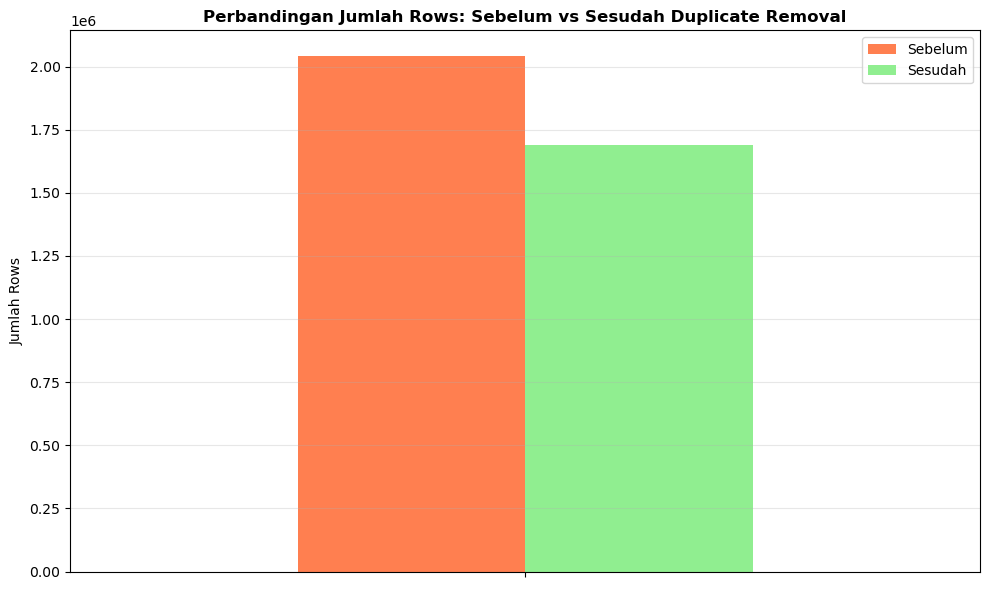


Visualisasi disimpan ke: artifacts_journal_based/step6_duplicate_removal.png


In [12]:
print("="*80)
print("STEP 6: DUPLICATE REMOVAL (TRAIN+VAL)")
print("="*80)

df_step6 = df_trainval.copy()

# Cek duplicates
rows_before = len(df_step6)
dups = df_step6.duplicated().sum()

print(f"\nSebelum duplicate removal:")
print(f"  Total rows: {rows_before:,}")
print(f"  Duplicate rows: {dups:,} ({dups/rows_before*100:.2f}%)")

# Remove duplicates
df_step6 = df_step6.drop_duplicates().copy()

rows_after = len(df_step6)
rows_dropped = rows_before - rows_after

print(f"\nSesudah duplicate removal:")
print(f"  Total rows: {rows_after:,}")
print(f"  Rows dropped: {rows_dropped:,} ({rows_dropped/rows_before*100:.2f}%)")

# Visualisasi
fig, ax = plt.subplots(figsize=(10, 6))
before_after = pd.DataFrame({
    'Sebelum': [rows_before],
    'Sesudah': [rows_after]
}, index=['Jumlah Rows'])
before_after.plot(kind='bar', ax=ax, color=['coral', 'lightgreen'])
ax.set_title('Perbandingan Jumlah Rows: Sebelum vs Sesudah Duplicate Removal', fontweight='bold')
ax.set_ylabel('Jumlah Rows')
ax.set_xticklabels([''], rotation=0)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(ART_DIR / 'step6_duplicate_removal.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step6_duplicate_removal.png'}")


## 12. Step 7: Zero-Variance & Correlation Pruning

**Berdasarkan jurnal**: "zero-variance or >0.95 correlation pruning reduced redundancy"


STEP 7: ZERO-VARIANCE & CORRELATION PRUNING



Total feature columns: 77

7a. Zero-Variance Removal:
  Columns before: 77
  Columns after: 69
  Dropped (zero variance): 8
  Dropped columns: ['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes/bulk', 'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 'bwd_avg_bytes/bulk', 'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate']

7b. Correlation Pruning (>0.95):
  Data besar (1,688,274 rows), menggunakan sample untuk correlation matrix...
  Computing correlation matrix... (shape: (69, 69))
  Highly correlated pairs (>0.95): 44
  Columns before correlation pruning: 69
  Columns after correlation pruning: 45
  Dropped (high correlation): 24
  Sample dropped columns (10 pertama): ['avg_bwd_segment_size', 'rst_flag_count', 'subflow_fwd_packets', 'idle_max', 'packet_length_mean', 'cwe_flag_count', 'fwd_packet_length_std', 'bwd_packet_length_std', 'idle_min', 'total_backward_packets']

Total columns dropped: 32
Final feature columns: 45


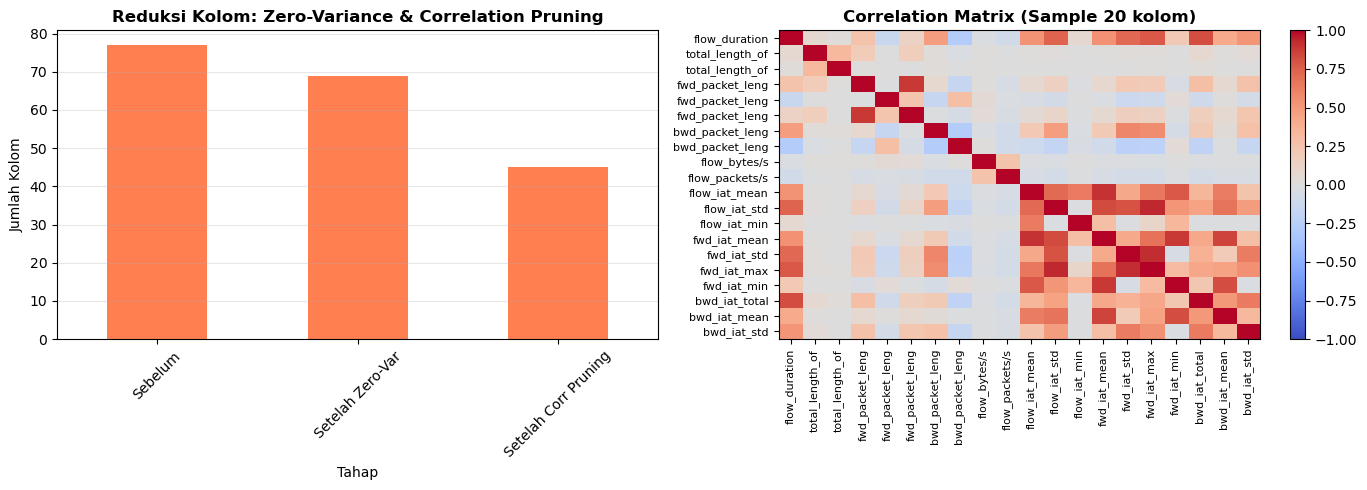


Visualisasi disimpan ke: artifacts_journal_based/step7_feature_pruning.png


In [13]:
print("="*80)
print("STEP 7: ZERO-VARIANCE & CORRELATION PRUNING")
print("="*80)

df_step7 = df_step6.copy()

# Exclude meta columns
exclude_meta = ['label', 'label_original', 'label_collapsed', 'source_file']
feature_cols = [c for c in df_step7.columns if c.lower() not in exclude_meta]

# Select numeric feature columns
numeric_feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_step7[c])]

print(f"\nTotal feature columns: {len(numeric_feature_cols)}")

# Step 7a: Zero-variance removal
print(f"\n7a. Zero-Variance Removal:")
var_threshold = VarianceThreshold(threshold=0.0)
X_features = df_step7[numeric_feature_cols].fillna(0)
var_threshold.fit(X_features)

# Get columns to keep
selected_cols_var = [numeric_feature_cols[i] for i in range(len(numeric_feature_cols)) if var_threshold.variances_[i] > 0]
dropped_zero_var = [c for c in numeric_feature_cols if c not in selected_cols_var]

print(f"  Columns before: {len(numeric_feature_cols)}")
print(f"  Columns after: {len(selected_cols_var)}")
print(f"  Dropped (zero variance): {len(dropped_zero_var)}")
if dropped_zero_var:
    print(f"  Dropped columns: {dropped_zero_var}")

# Step 7b: Correlation pruning (>0.95)
print(f"\n7b. Correlation Pruning (>{CORR_THRESHOLD}):")
X_corr = df_step7[selected_cols_var].fillna(0)

# Optimasi: Gunakan sample jika data terlalu besar untuk correlation matrix
if len(X_corr) > 100000:
    print(f"  Data besar ({len(X_corr):,} rows), menggunakan sample untuk correlation matrix...")
    sample_size = min(100000, len(X_corr))
    X_corr_sample = X_corr.sample(n=sample_size, random_state=RANDOM_STATE)
    corr_matrix = X_corr_sample.corr().abs()
else:
    corr_matrix = X_corr.corr().abs()

print(f"  Computing correlation matrix... (shape: {corr_matrix.shape})")

# Find highly correlated pairs - optimasi dengan numpy
high_corr_pairs = []
corr_matrix_np = corr_matrix.values
n_cols = len(corr_matrix.columns)

# Gunakan numpy untuk lebih efisien
for i in range(n_cols):
    for j in range(i+1, n_cols):
        if corr_matrix_np[i, j] > CORR_THRESHOLD:
            high_corr_pairs.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix_np[i, j]
            ))

print(f"  Highly correlated pairs (>{CORR_THRESHOLD}): {len(high_corr_pairs)}")

# Drop one column from each highly correlated pair
cols_to_drop_corr = set()
var_dict = {col: X_corr[col].var() for col in selected_cols_var}  # Pre-compute variances

for col1, col2, corr_val in high_corr_pairs:
    # Keep column with higher variance, drop the other
    var1 = var_dict[col1]
    var2 = var_dict[col2]
    if var1 >= var2:
        cols_to_drop_corr.add(col2)
    else:
        cols_to_drop_corr.add(col1)

cols_to_drop_corr = list(cols_to_drop_corr)
selected_cols_final = [c for c in selected_cols_var if c not in cols_to_drop_corr]

print(f"  Columns before correlation pruning: {len(selected_cols_var)}")
print(f"  Columns after correlation pruning: {len(selected_cols_final)}")
print(f"  Dropped (high correlation): {len(cols_to_drop_corr)}")
if cols_to_drop_corr:
    print(f"  Sample dropped columns (10 pertama): {cols_to_drop_corr[:10]}")

# Update dataframe
dropped_cols_total = dropped_zero_var + cols_to_drop_corr
df_step7 = df_step7.drop(columns=dropped_cols_total, errors='ignore').copy()

print(f"\nTotal columns dropped: {len(dropped_cols_total)}")
print(f"Final feature columns: {len(selected_cols_final)}")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Column reduction
reduction_df = pd.DataFrame({
    'Sebelum': [len(numeric_feature_cols)],
    'Setelah Zero-Var': [len(selected_cols_var)],
    'Setelah Corr Pruning': [len(selected_cols_final)]
}, index=['Jumlah Kolom'])
reduction_df.T.plot(kind='bar', ax=axes[0], color=['coral', 'orange', 'lightgreen'])
axes[0].set_title('Reduksi Kolom: Zero-Variance & Correlation Pruning', fontweight='bold')
axes[0].set_ylabel('Jumlah Kolom')
axes[0].set_xlabel('Tahap')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend().remove()
axes[0].grid(axis='y', alpha=0.3)

# Correlation heatmap (sample)
if len(selected_cols_final) > 1:
    sample_cols = selected_cols_final[:20]  # Sample 20 kolom untuk heatmap
    corr_sample = df_step7[sample_cols].corr()
    im = axes[1].imshow(corr_sample, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1].set_title(f'Correlation Matrix (Sample {len(sample_cols)} kolom)', fontweight='bold')
    axes[1].set_xticks(range(len(sample_cols)))
    axes[1].set_yticks(range(len(sample_cols)))
    axes[1].set_xticklabels([c[:15] for c in sample_cols], rotation=90, fontsize=8)
    axes[1].set_yticklabels([c[:15] for c in sample_cols], fontsize=8)
    plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.savefig(ART_DIR / 'step7_feature_pruning.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step7_feature_pruning.png'}")


## 13. Step 8: Split Train+Val menjadi Train (70%) dan Validation (15%)

**Berdasarkan jurnal**: "Stratified sampling was used to split the sanitized data into training (70%), validation (15%), and test (15%)"


STEP 8: SPLIT TRAIN+VAL MENJADI TRAIN (70%) DAN VALIDATION (15%)

Split results (dari total original 2,401,398 rows):
  Train: 1,390,343 rows (57.90%)
  Validation: 297,931 rows (12.41%)
  Test: 360,210 rows (15.00%)
  Total: 2,048,484 rows

Class distribution - Train:
label_collapsed
BENIGN         1190956
Brute Force       6464
DDoS             76171
DoS             115488
Port Scan         1264
Name: count, dtype: int64

Class distribution - Validation:
label_collapsed
BENIGN         255205
Brute Force      1385
DDoS            16323
DoS             24747
Port Scan         271
Name: count, dtype: int64

Class distribution - Test:
label_collapsed
BENIGN         289592
Brute Force      1956
DDoS            16323
DoS             32092
Port Scan       20247
Name: count, dtype: int64


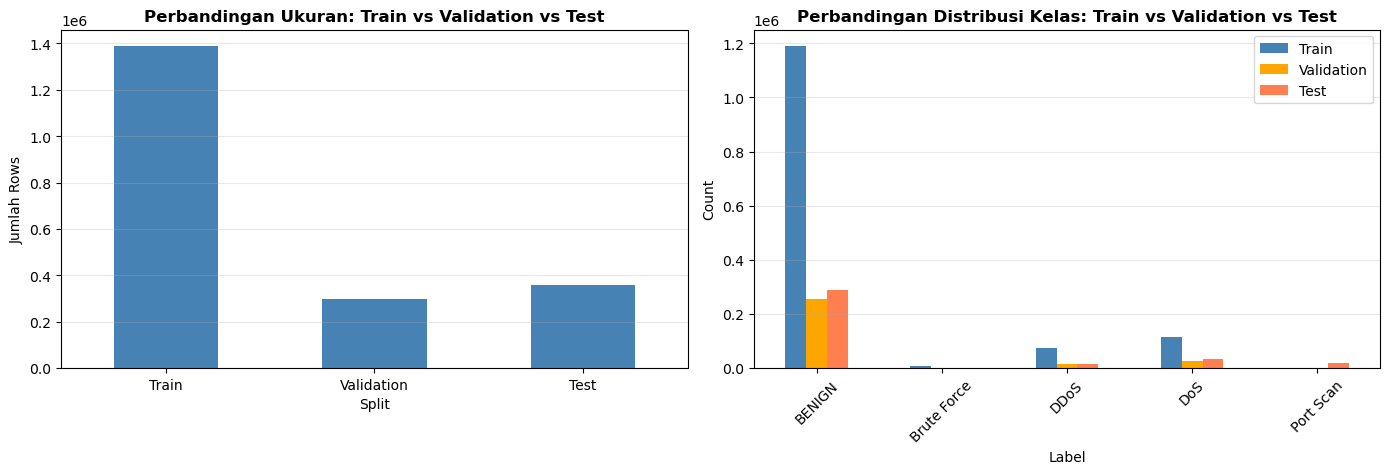


Visualisasi disimpan ke: artifacts_journal_based/step8_train_val_split.png


In [14]:
print("="*80)
print("STEP 8: SPLIT TRAIN+VAL MENJADI TRAIN (70%) DAN VALIDATION (15%)")
print("="*80)

# Split 85% menjadi train (70% dari total) dan validation (15% dari total)
# Dari 85%, kita perlu split menjadi ~82.35% train dan ~17.65% validation
# untuk mendapatkan 70% dan 15% dari total original

# Hitung proporsi yang tepat
# Jika 85% = 100%, maka:
# - Train harus 70% dari total = 70/85 = 82.35% dari 85%
# - Val harus 15% dari total = 15/85 = 17.65% dari 85%
val_size_from_trainval = 15 / 85  # ~0.1765

df_train, df_val = train_test_split(
    df_step7,
    test_size=val_size_from_trainval,
    stratify=df_step7['label_collapsed'],
    random_state=RANDOM_STATE
)

# Verifikasi proporsi dari total original
total_original = len(df_step4)
train_pct = len(df_train) / total_original * 100
val_pct = len(df_val) / total_original * 100
test_pct = len(df_test) / total_original * 100

print(f"\nSplit results (dari total original {total_original:,} rows):")
print(f"  Train: {len(df_train):,} rows ({train_pct:.2f}%)")
print(f"  Validation: {len(df_val):,} rows ({val_pct:.2f}%)")
print(f"  Test: {len(df_test):,} rows ({test_pct:.2f}%)")
print(f"  Total: {len(df_train) + len(df_val) + len(df_test):,} rows")

print(f"\nClass distribution - Train:")
print(df_train['label_collapsed'].value_counts().sort_index())

print(f"\nClass distribution - Validation:")
print(df_val['label_collapsed'].value_counts().sort_index())

print(f"\nClass distribution - Test:")
print(df_test['label_collapsed'].value_counts().sort_index())

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Size comparison
size_df = pd.DataFrame({
    'Train': [len(df_train)],
    'Validation': [len(df_val)],
    'Test': [len(df_test)]
}, index=['Jumlah Rows'])
size_df.T.plot(kind='bar', ax=axes[0], color=['steelblue', 'orange', 'coral'])
axes[0].set_title('Perbandingan Ukuran: Train vs Validation vs Test', fontweight='bold')
axes[0].set_ylabel('Jumlah Rows')
axes[0].set_xlabel('Split')
axes[0].tick_params(axis='x', rotation=0)
axes[0].legend().remove()
axes[0].grid(axis='y', alpha=0.3)

# Class distribution comparison
train_dist = df_train['label_collapsed'].value_counts().sort_index()
val_dist = df_val['label_collapsed'].value_counts().sort_index()
test_dist = df_test['label_collapsed'].value_counts().sort_index()
dist_comparison = pd.DataFrame({
    'Train': train_dist,
    'Validation': val_dist,
    'Test': test_dist
}).fillna(0)
dist_comparison.plot(kind='bar', ax=axes[1], color=['steelblue', 'orange', 'coral'])
axes[1].set_title('Perbandingan Distribusi Kelas: Train vs Validation vs Test', fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Label')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(ART_DIR / 'step8_train_val_split.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step8_train_val_split.png'}")


## 14. Step 9: QuantileTransformer + MinMaxScaler (Fitted on Train Only)

**Berdasarkan jurnal**: "We then applied a QuantileTransformer (Gaussian output) fitted only to the training fold, followed by the MinMaxScaler"

**Catatan**: Test set TIDAK di-transform di preprocessing ini. Test set akan di-transform saat inference menggunakan transformer yang sudah di-fit pada train.


STEP 9: QUANTILETRANSFORMER + MINMAXSCALER (FIT ON TRAIN ONLY)

Feature columns untuk transform: 45



Data shapes:
  X_train: (1390343, 45)
  X_val: (297931, 45)
  ⚠️ Test set TIDAK di-transform di preprocessing

9a. Fitting QuantileTransformer on train...
  ✓ QuantileTransformer fitted on train only
  ✓ Applied to train and validation only
  ⚠️ Test set akan di-transform saat inference menggunakan transformer ini

9b. Fitting MinMaxScaler on train...
  ✓ MinMaxScaler fitted on train only
  ✓ Applied to train and validation only
  ⚠️ Test set akan di-transform saat inference menggunakan transformer ini

Final shapes:
  Train: (1390343, 46)
  Validation: (297931, 46)
  Test (belum di-transform): (360210, 46)


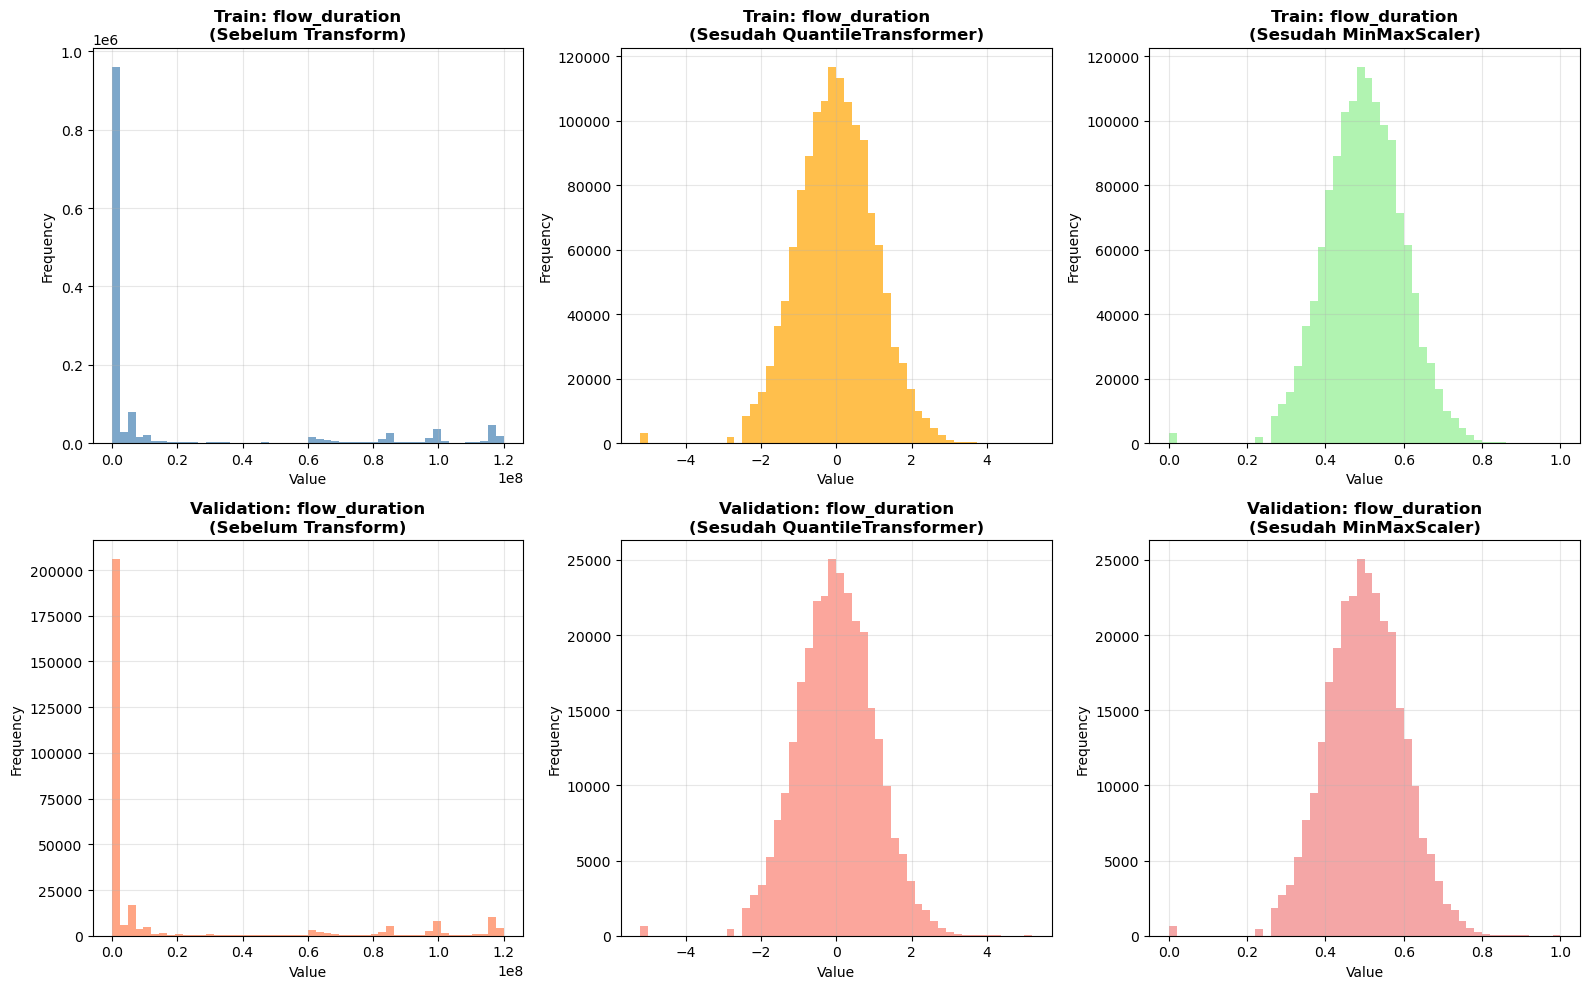


Visualisasi disimpan ke: artifacts_journal_based/step9_scaling_transform.png

✓ Transform metadata saved to: artifacts_journal_based/transform_meta.pkl


In [15]:
print("="*80)
print("STEP 9: QUANTILETRANSFORMER + MINMAXSCALER (FIT ON TRAIN ONLY)")
print("="*80)

# Prepare feature columns (exclude meta)
exclude_meta = ['label', 'label_original', 'label_collapsed', 'source_file']
feature_cols = [c for c in df_train.columns if c.lower() not in exclude_meta]
feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_train[c])]

print(f"\nFeature columns untuk transform: {len(feature_cols)}")

# Prepare data (HANYA train dan val, test TIDAK di-transform di preprocessing)
X_train = df_train[feature_cols].fillna(0)
X_val = df_val[feature_cols].fillna(0)
# Test set TIDAK di-transform di preprocessing (akan di-transform saat inference)

print(f"\nData shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  ⚠️ Test set TIDAK di-transform di preprocessing")

# Step 9a: QuantileTransformer (Gaussian output) - FIT ON TRAIN ONLY
print(f"\n9a. Fitting QuantileTransformer on train...")
qt = QuantileTransformer(output_distribution='normal', random_state=RANDOM_STATE)
X_train_qt = qt.fit_transform(X_train)
X_val_qt = qt.transform(X_val)
# Test TIDAK di-transform di sini (akan di-transform saat inference menggunakan transformer ini)

print(f"  ✓ QuantileTransformer fitted on train only")
print(f"  ✓ Applied to train and validation only")
print(f"  ⚠️ Test set akan di-transform saat inference menggunakan transformer ini")

# Step 9b: MinMaxScaler - FIT ON TRAIN ONLY
print(f"\n9b. Fitting MinMaxScaler on train...")
mm_scaler = MinMaxScaler()
X_train_scaled = mm_scaler.fit_transform(X_train_qt)
X_val_scaled = mm_scaler.transform(X_val_qt)
# Test TIDAK di-transform di sini

print(f"  ✓ MinMaxScaler fitted on train only")
print(f"  ✓ Applied to train and validation only")
print(f"  ⚠️ Test set akan di-transform saat inference menggunakan transformer ini")

# Convert back to DataFrame
df_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=df_train.index)
df_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=df_val.index)
# Test tetap dalam bentuk original (belum di-transform)
df_test_scaled = df_test[feature_cols + ['label_collapsed']].copy()

# Add label columns back
df_train_scaled['label_collapsed'] = df_train['label_collapsed'].values
df_val_scaled['label_collapsed'] = df_val['label_collapsed'].values

print(f"\nFinal shapes:")
print(f"  Train: {df_train_scaled.shape}")
print(f"  Validation: {df_val_scaled.shape}")
print(f"  Test (belum di-transform): {df_test_scaled.shape}")

# Visualisasi: Distribusi sebelum dan sesudah transform (sample feature)
sample_feature = feature_cols[0] if feature_cols else None
if sample_feature:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    # Train: Before
    axes[0, 0].hist(X_train[sample_feature].values, bins=50, color='steelblue', alpha=0.7)
    axes[0, 0].set_title(f'Train: {sample_feature}\n(Sebelum Transform)', fontweight='bold')
    axes[0, 0].set_xlabel('Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(alpha=0.3)
    
    # Train: After QuantileTransformer
    axes[0, 1].hist(X_train_qt[:, 0], bins=50, color='orange', alpha=0.7)
    axes[0, 1].set_title(f'Train: {sample_feature}\n(Sesudah QuantileTransformer)', fontweight='bold')
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(alpha=0.3)
    
    # Train: After MinMaxScaler
    axes[0, 2].hist(X_train_scaled[:, 0], bins=50, color='lightgreen', alpha=0.7)
    axes[0, 2].set_title(f'Train: {sample_feature}\n(Sesudah MinMaxScaler)', fontweight='bold')
    axes[0, 2].set_xlabel('Value')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].grid(alpha=0.3)
    
    # Validation: Before
    axes[1, 0].hist(X_val[sample_feature].values, bins=50, color='coral', alpha=0.7)
    axes[1, 0].set_title(f'Validation: {sample_feature}\n(Sebelum Transform)', fontweight='bold')
    axes[1, 0].set_xlabel('Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(alpha=0.3)
    
    # Validation: After QuantileTransformer
    axes[1, 1].hist(X_val_qt[:, 0], bins=50, color='salmon', alpha=0.7)
    axes[1, 1].set_title(f'Validation: {sample_feature}\n(Sesudah QuantileTransformer)', fontweight='bold')
    axes[1, 1].set_xlabel('Value')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(alpha=0.3)
    
    # Validation: After MinMaxScaler
    axes[1, 2].hist(X_val_scaled[:, 0], bins=50, color='lightcoral', alpha=0.7)
    axes[1, 2].set_title(f'Validation: {sample_feature}\n(Sesudah MinMaxScaler)', fontweight='bold')
    axes[1, 2].set_xlabel('Value')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ART_DIR / 'step9_scaling_transform.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step9_scaling_transform.png'}")

# Save transformers
transform_meta = {
    'quantile_transformer': qt,
    'minmax_scaler': mm_scaler,
    'feature_cols': feature_cols,
    'fit_on': 'train_only',
    'n_fit_samples': len(X_train)
}

joblib.dump(transform_meta, TRANSFORM_META_PATH)
print(f"\n✓ Transform metadata saved to: {TRANSFORM_META_PATH}")


## 15. Step 10: Consensus Feature Selection

**Berdasarkan jurnal**: Feature selection menggunakan Random Forest Gini importance, Mutual Information, dan χ2 domain heuristic.


STEP 10: CONSENSUS FEATURE SELECTION



Feature selection methods:
  1. Random Forest Gini Importance
  2. Mutual Information
  3. Chi2 (domain heuristic)

1. Computing Random Forest Gini Importance...
2. Computing Mutual Information...
3. Computing Chi2 scores...

4. Combining rankings...

Consensus features selected: 10
  RF+MI intersection: 8 features
  Chi2 padding: 2 features

Selected features:
  1. max_packet_length
     RF Rank: 2, MI Rank: 4, Chi2 Rank: 27
  2. average_packet_size
     RF Rank: 4, MI Rank: 1, Chi2 Rank: 28
  3. total_length_of_bwd_packets
     RF Rank: 5, MI Rank: 2, Chi2 Rank: 35
  4. fwd_packet_length_max
     RF Rank: 8, MI Rank: 10, Chi2 Rank: 38
  5. init_win_bytes_backward
     RF Rank: 9, MI Rank: 7, Chi2 Rank: 11
  6. packet_length_variance
     RF Rank: 1, MI Rank: 3, Chi2 Rank: 24
  7. total_length_of_fwd_packets
     RF Rank: 6, MI Rank: 6, Chi2 Rank: 40
  8. bwd_packet_length_max
     RF Rank: 3, MI Rank: 5, Chi2 Rank: 29
  9. active_mean
     RF Rank: 27, MI Rank: 25, Chi2 Rank: 3
  10

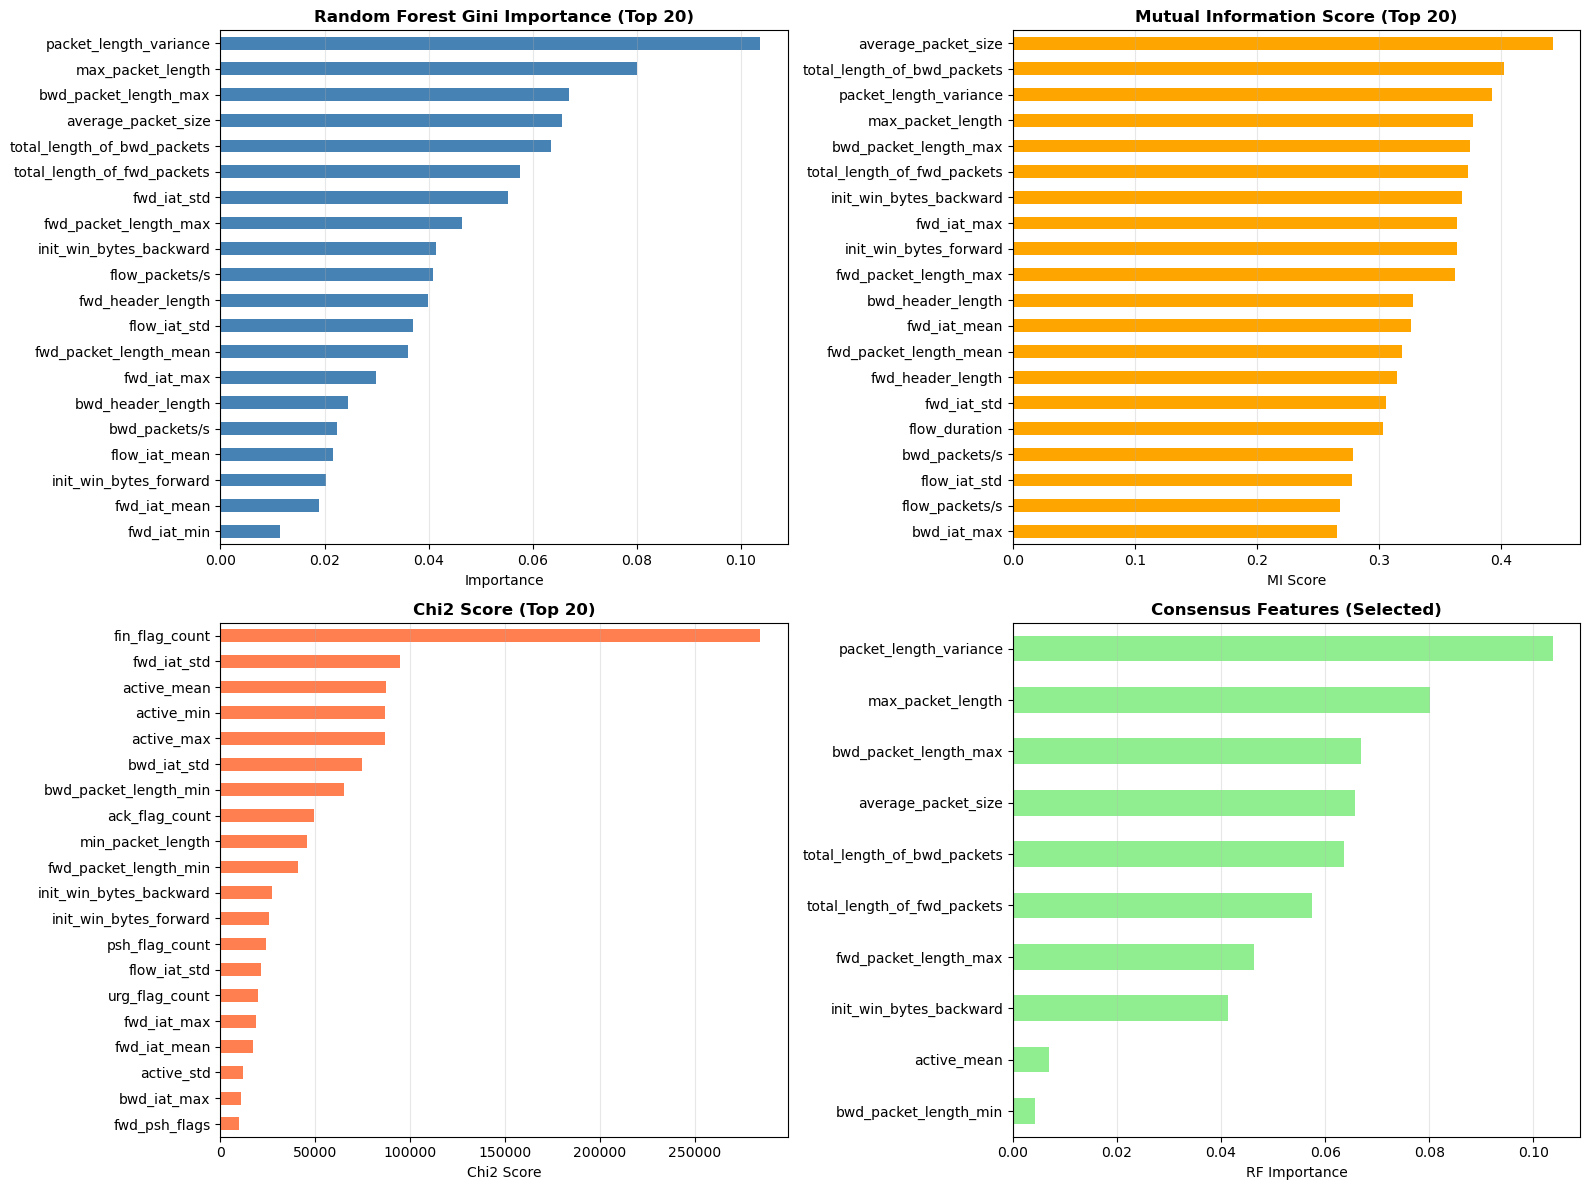


Visualisasi disimpan ke: artifacts_journal_based/step10_feature_selection.png

Final feature columns: 10
Feature columns saved to: artifacts_journal_based/feature_cols.json


In [16]:
print("="*80)
print("STEP 10: CONSENSUS FEATURE SELECTION")
print("="*80)

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif, chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder

# Prepare data
X_train_feat = df_train_scaled[feature_cols].values
y_train_feat = df_train_scaled['label_collapsed'].values

# Encode labels untuk feature selection
le_feat = LabelEncoder()
y_train_encoded = le_feat.fit_transform(y_train_feat)

print(f"\nFeature selection methods:")
print(f"  1. Random Forest Gini Importance")
print(f"  2. Mutual Information")
print(f"  3. Chi2 (domain heuristic)")

# Method 1: Random Forest Importance
print(f"\n1. Computing Random Forest Gini Importance...")
rf_feat = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_feat.fit(X_train_feat, y_train_encoded)
rf_importance = pd.Series(rf_feat.feature_importances_, index=feature_cols).sort_values(ascending=False)

# Method 2: Mutual Information
print(f"2. Computing Mutual Information...")
mi_scores = mutual_info_classif(X_train_feat, y_train_encoded, random_state=RANDOM_STATE)
mi_importance = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)

# Method 3: Chi2 (hanya untuk non-negative values)
print(f"3. Computing Chi2 scores...")
# Chi2 requires non-negative values, kita sudah punya MinMaxScaler (0-1 range)
chi2_scores, _ = chi2(X_train_feat, y_train_encoded)
chi2_importance = pd.Series(chi2_scores, index=feature_cols).sort_values(ascending=False)

# Combine rankings
print(f"\n4. Combining rankings...")
rankings = pd.DataFrame({
    'RF_Rank': rf_importance.rank(ascending=False),
    'MI_Rank': mi_importance.rank(ascending=False),
    'Chi2_Rank': chi2_importance.rank(ascending=False),
    'RF_Score': rf_importance,
    'MI_Score': mi_importance,
    'Chi2_Score': chi2_importance
})

# Consensus: Top features dari RF dan MI intersection, plus top Chi2
n_top_features = 10  # Berdasarkan jurnal: 10 features per task

# Top N dari RF
top_rf = set(rf_importance.head(n_top_features).index)
# Top N dari MI
top_mi = set(mi_importance.head(n_top_features).index)
# Intersection
rf_mi_intersection = top_rf & top_mi
# Top N dari Chi2 untuk padding
top_chi2 = set(chi2_importance.head(n_top_features).index)

# Consensus features: RF+MI intersection + Chi2 top
consensus_features = list(rf_mi_intersection) + [f for f in top_chi2 if f not in rf_mi_intersection]
consensus_features = consensus_features[:n_top_features]  # Ambil top 10

print(f"\nConsensus features selected: {len(consensus_features)}")
print(f"  RF+MI intersection: {len(rf_mi_intersection)} features")
print(f"  Chi2 padding: {len(consensus_features) - len(rf_mi_intersection)} features")
print(f"\nSelected features:")
for i, feat in enumerate(consensus_features, 1):
    rf_rank = rankings.loc[feat, 'RF_Rank']
    mi_rank = rankings.loc[feat, 'MI_Rank']
    chi2_rank = rankings.loc[feat, 'Chi2_Rank']
    print(f"  {i}. {feat}")
    print(f"     RF Rank: {rf_rank:.0f}, MI Rank: {mi_rank:.0f}, Chi2 Rank: {chi2_rank:.0f}")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RF Importance Top 20
rf_importance.head(20).plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_title('Random Forest Gini Importance (Top 20)', fontweight='bold')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# MI Importance Top 20
mi_importance.head(20).plot(kind='barh', ax=axes[0, 1], color='orange')
axes[0, 1].set_title('Mutual Information Score (Top 20)', fontweight='bold')
axes[0, 1].set_xlabel('MI Score')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Chi2 Importance Top 20
chi2_importance.head(20).plot(kind='barh', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Chi2 Score (Top 20)', fontweight='bold')
axes[1, 0].set_xlabel('Chi2 Score')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Consensus features
consensus_df = rankings.loc[consensus_features].sort_values('RF_Score', ascending=False)
consensus_df['RF_Score'].plot(kind='barh', ax=axes[1, 1], color='lightgreen')
axes[1, 1].set_title('Consensus Features (Selected)', fontweight='bold')
axes[1, 1].set_xlabel('RF Importance')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(ART_DIR / 'step10_feature_selection.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {ART_DIR / 'step10_feature_selection.png'}")

# Update feature columns
final_feature_cols = consensus_features
print(f"\nFinal feature columns: {len(final_feature_cols)}")

# Save feature columns
with open(FEATURE_COLS_PATH, 'w') as f:
    json.dump(final_feature_cols, f, indent=2)
print(f"Feature columns saved to: {FEATURE_COLS_PATH}")


## 16. Step 11: Finalize Processed Datasets


In [17]:
print("="*80)
print("STEP 11: FINALIZE PROCESSED DATASETS")
print("="*80)

# Select final features
df_train_final = df_train_scaled[final_feature_cols + ['label_collapsed']].copy()
df_val_final = df_val_scaled[final_feature_cols + ['label_collapsed']].copy()

# Test: Simpan dengan 45 features (BELUM di-transform, sebelum feature selection)
# Ini diperlukan karena transformer di-fit pada 45 features
# Test set akan di-transform dengan 45 features di pemodelan, lalu di-select menjadi 10 features
# df_test_scaled hanya copy dari df_test, belum di-transform
# Kita perlu menggunakan df_test yang masih memiliki 45 features (dari df_step7)
# Tapi df_test sudah di-split dari df_step4, jadi kita perlu menggunakan feature_cols dari df_step7
df_test_final = df_test[feature_cols + ['label_collapsed']].copy()

# Encode labels
df_train_final['label_encoded'] = df_train_final['label_collapsed'].map(label_map)
df_val_final['label_encoded'] = df_val_final['label_collapsed'].map(label_map)
df_test_final['label_encoded'] = df_test_final['label_collapsed'].map(label_map)

print(f"\nFinal datasets:")
print(f"  Train: {df_train_final.shape}")
print(f"  Validation: {df_val_final.shape}")
print(f"  Test: {df_test_final.shape}")

print(f"\nFeature columns: {len(final_feature_cols)}")
print(f"Label classes: {len(label_map)}")

# Save processed datasets
joblib.dump(df_train_final, TRAIN_PROC_PATH)
joblib.dump(df_val_final, VAL_PROC_PATH)
joblib.dump(df_test_final, TEST_PROC_PATH)

print(f"\n✓ Processed datasets saved:")
print(f"  Train: {TRAIN_PROC_PATH}")
print(f"  Validation: {VAL_PROC_PATH}")
print(f"  Test: {TEST_PROC_PATH}")

# Save label maps
with open(LABEL_MAP_PATH, 'w') as f:
    json.dump({'label_map': label_map, 'inv_label_map': inv_label_map}, f, indent=2)
print(f"  Label maps: {LABEL_MAP_PATH}")

# Summary statistics
summary = {
    'original_rows': len(raw_df),
    'after_filtering': len(raw_df_filtered),
    'after_nan_inf_removal': len(df_step4),
    'after_duplicate_removal': len(df_step6),
    'train_rows': len(df_train_final),
    'val_rows': len(df_val_final),
    'test_rows': len(df_test_final),
    'original_cols': len(raw_df.columns),
    'after_leakage_drop': len(df_step1.columns),
    'final_feature_cols': len(final_feature_cols),
    'label_classes': len(label_map)
}

summary_path = ART_DIR / 'preprocessing_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"  Summary: {summary_path}")

print(f"\n{'='*80}")
print("PREPROCESSING COMPLETE!")
print(f"{'='*80}")


STEP 11: FINALIZE PROCESSED DATASETS

Final datasets:
  Train: (1390343, 12)
  Validation: (297931, 12)
  Test: (360210, 47)

Feature columns: 10
Label classes: 5



✓ Processed datasets saved:
  Train: artifacts_journal_based/train_processed.pkl
  Validation: artifacts_journal_based/val_processed.pkl
  Test: artifacts_journal_based/test_processed.pkl
  Label maps: artifacts_journal_based/label_map.json
  Summary: artifacts_journal_based/preprocessing_summary.json

PREPROCESSING COMPLETE!


## 17. EDA: Summary & Final Statistics


EDA: SUMMARY & FINAL STATISTICS

Preprocessing Pipeline Summary:
                    Stage    Rows  Columns  Rows_Reduction
                 Original 2830743       82        0.000000
    After Label Filtering 2828057       82       -0.094887
After Drop Leakage Fields 2403848       81      -15.000016
     After Remove NaN/Inf 2401398       81       -0.101920
  After Duplicate Removal 1688274       81      -29.696202
    After Feature Pruning 1688274       49        0.000000
              Final Train 1390343       12      -17.647076
         Final Validation  297931       12      -78.571403
               Final Test  360210       47       20.903833


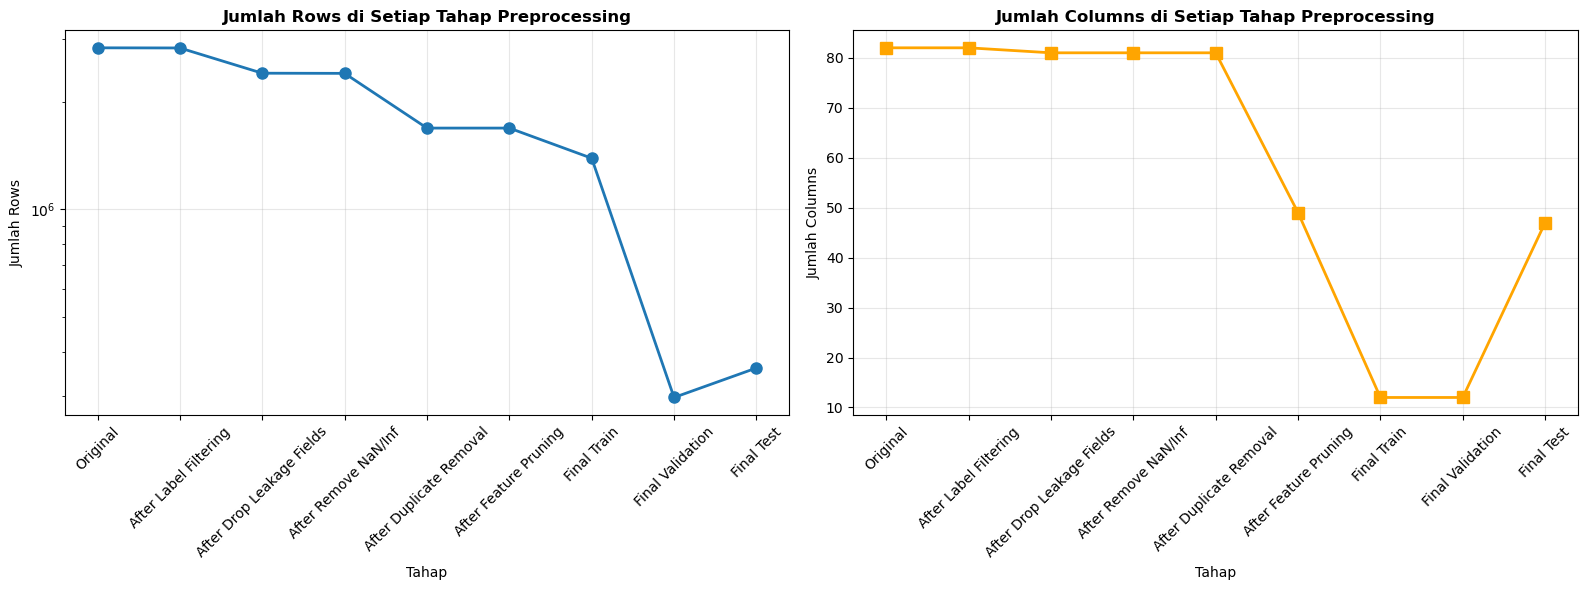


Visualisasi disimpan ke: artifacts_journal_based/eda_preprocessing_pipeline.png

Final Class Distribution:

Train:
label_collapsed
BENIGN         1190956
Brute Force       6464
DDoS             76171
DoS             115488
Port Scan         1264
Name: count, dtype: int64

Validation:
label_collapsed
BENIGN         255205
Brute Force      1385
DDoS            16323
DoS             24747
Port Scan         271
Name: count, dtype: int64

Test:
label_collapsed
BENIGN         289592
Brute Force      1956
DDoS            16323
DoS             32092
Port Scan       20247
Name: count, dtype: int64


In [18]:
print("="*80)
print("EDA: SUMMARY & FINAL STATISTICS")
print("="*80)

# Summary table
summary_table = pd.DataFrame({
    'Stage': [
        'Original',
        'After Label Filtering',
        'After Drop Leakage Fields',
        'After Remove NaN/Inf',
        'After Duplicate Removal',
        'After Feature Pruning',
        'Final Train',
        'Final Validation',
        'Final Test'
    ],
    'Rows': [
        len(raw_df),
        len(raw_df_filtered),
        len(df_step1),
        len(df_step4),
        len(df_step6),
        len(df_step7),
        len(df_train_final),
        len(df_val_final),
        len(df_test_final)
    ],
    'Columns': [
        len(raw_df.columns),
        len(raw_df_filtered.columns),
        len(df_step1.columns),
        len(df_step4.columns),
        len(df_step6.columns),
        len(df_step7.columns),
        len(df_train_final.columns),
        len(df_val_final.columns),
        len(df_test_final.columns)
    ]
})

summary_table['Rows_Reduction'] = summary_table['Rows'].pct_change() * 100
summary_table['Rows_Reduction'] = summary_table['Rows_Reduction'].fillna(0)

print("\nPreprocessing Pipeline Summary:")
print(summary_table.to_string(index=False))

# Visualisasi pipeline
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Rows reduction
axes[0].plot(summary_table['Stage'], summary_table['Rows'], marker='o', linewidth=2, markersize=8)
axes[0].set_title('Jumlah Rows di Setiap Tahap Preprocessing', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Jumlah Rows')
axes[0].set_xlabel('Tahap')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)
axes[0].set_yscale('log')

# Columns reduction
axes[1].plot(summary_table['Stage'], summary_table['Columns'], marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_title('Jumlah Columns di Setiap Tahap Preprocessing', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Jumlah Columns')
axes[1].set_xlabel('Tahap')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(ART_DIR / 'eda_preprocessing_pipeline.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualisasi disimpan ke: {ART_DIR / 'eda_preprocessing_pipeline.png'}")

# Class distribution final
print(f"\nFinal Class Distribution:")
print(f"\nTrain:")
print(df_train_final['label_collapsed'].value_counts().sort_index())
print(f"\nValidation:")
print(df_val_final['label_collapsed'].value_counts().sort_index())
print(f"\nTest:")
print(df_test_final['label_collapsed'].value_counts().sort_index())
